# modul import

In [ ]:
# modules import

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

<ipython-input-63-2c45c0f907c0>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


# GPU 사용

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# 전처리 설정

In [ ]:
# transform: 데이터를 조작하고 학습에 적합하게 만들기 위해서 사용함.
#transforms.Compose: 여러 단계로 변환해야 하는 경우, Compose를 통해 여러 단계를 묶을 수 있음.
# transforms.ToTensor(): 데이터를 tensor로 바꿔줌.
# transforms.Normalize(mean, std, inplace=False): 정규화


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# 데이터 로드 및 데이터 확인

torchvision을 통해 데이터를 다운

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', # 다운 받을 경로
                                      train=True, # 인자로 True를 주면, MNIST의 훈련 데이터를 리턴 받음.
                                      download=True, # 해당 경로에 MNIST 데이터가 없다면 다운로드 받겠다.
                                      transform=transform) # 위에서 전처리 설정한 것으로 변환시켜줌.

testset = torchvision.datasets.MNIST(root='./data',
                                      train=False, # 인자로 False를 주면, MNIST의 테스트 데이터를 리턴 받음.
                                      download=True,
                                      transform=transform)

DataLoader
- DataLoader 클래스는 데이터셋을 샘플러와 병합하여 iterable한 형태로 출력해줌.


In [ ]:
train_loader = DataLoader(trainset,
                          batch_size=128, # 배치 크기는 128
                          shuffle=True, # 매 에포크마다 미니 배치를 셔플할 것인지 여부
                          num_workers =2 )

test_loader = DataLoader(testset,
                         batch_size=128,
                         shuffle=False,
                         num_workers = 2) # 데이터를 불러올때 subprocess를 몇개 사용할 것인지 (에러가 나면 0으로 설정)

# 에포크는 전체 데이터 셋이 신경망을 통과한 횟수 의미함, 즉 모든 데이터셋을 학습 하는 횟수이다.
# 즉 shuffle은 전체 학습 데이터를 배열 인덱스와 관계없이 만드는 작업으로, 과적합(overfitting)을 막고자 함.
# subprocss: 파이썬 스크립트에서 쉘 명령 등 다른 프로세스를 실행하고 출력 결과를 가져올 수 있게 해주는 라이브러리

In [ ]:
image, label = next(iter(train_loader))

# 데이터를 하나씩 불러온다.

In [ ]:
image.shape, label.shape

# MNIST data image of shape 28 * 28 = 784
# torch.Size([배치사이즈, 채널수, 이미지 너비, 이미지 높이])

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

데이터 속 이미지 확인

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  fig = plt.figure(figsize=(10,5))
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

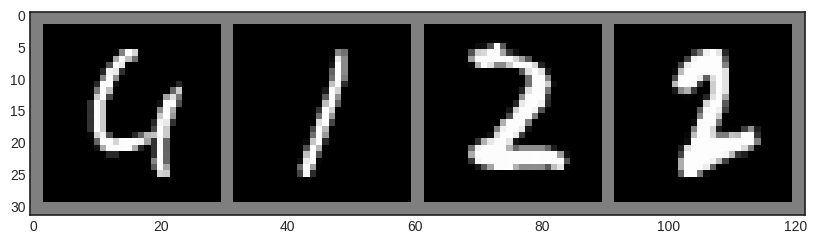

In [ ]:
# 이미지 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

## 신경망 구성

Conv2d

- 주로 Conv2d는 이미지 분류에서 많이 사용한다.
- Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

pooling layer

- Convolution을 거쳐서 나온 activation maps이 있을 때, 이를 이루는 convolution layer을 resizing하여 새로운 layer를 얻는 것
- 최댓값을 뽑아내는 max pooling과 평균값을 뽑아내는 mean pooling 등이 있음.
- MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

In [ ]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    # 첫번째 합성곱 층 구현, 1 input image channel, 6 output channels, 3x3 square convolution
    self.conv1 = nn.Conv2d(1,6,3)
    # 두번째 합성곱 층 구현, 6 input image channel, 16 output channels, 3x3 square convolution
    self.conv2 = nn.Conv2d(6, 16, 3)
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(16*5*5,120) # 5*5 from image dimension
    self.fc2 = nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)

  def forward(self, x):
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
    # If the size is a square you can only specify a single number
    x = F.max_pool2d(F.relu(self.conv2(x)),2)
    x = x.view(-1,self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self,x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features  *= s

    return num_features

net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
net = Net().to(device)

# 손실함수와 옵티마이저

분류를 위한 Cross-Entropy 손실 함수와 모멘텀을 설정한 SGD 옵티마이저 사용
* SGD옵티마이저: 전체가 아니라 배치 단위로 가중치를 업데이트 하자는 아이디어를 통해 만들어졌으며, 옵티마이저는 가중치를 업데이트하는 알고리즘이다.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 모델 학습

- optimizer.zero_grad: 가중치의 그레디언트 초기화
- loss 계산
- loss.backward()
- optimizzer.step(): 업데이트

배치수 확인

In [ ]:
total_batch = len(train_loader)
print(total_batch)

469


In [ ]:
for epoch in range(2): # 데이터셋을 수차례 반복

    running_loss = 0.0
    for i, data in enumerate(train_loader,0):
      # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
      inputs, labels = data[0].to(device), data[1].to(device)

      # 변화도 매개변수를 0으로 만듦.
      optimizer.zero_grad()

      # 순전파 + 역전파 + 최적화
      outputs = net(inputs)
      loss = criterion(outputs, labels) # 손실 함수를 이용한 오차 계산
      loss.backward() # 모델의 학습 가능한 모든 파라미터에 대해 기울기를 계산
      optimizer.step() # optimizer의 step 함수를 호출하면 파라미터를 갱신

      # 평균 손실 출력
      running_loss += loss.item()
      if i%100==99 :
        print("Epoch: {}, Iter: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
        running_loss = 0.

# running_loss를 2000으로 나누는 이유는 평균 손실을 계산하기 위해서. 코드에서는 매 100번의 미니배치(100번의 반복)마다 running_loss에 손실을 더하고, 그 값을 2000으로 나눠서 출력.

Epoch: 1, Iter: 100, Loss: 0.11507568144798279
Epoch: 1, Iter: 200, Loss: 0.11477261340618133
Epoch: 1, Iter: 300, Loss: 0.1143971117734909
Epoch: 1, Iter: 400, Loss: 0.11389781856536865
Epoch: 2, Iter: 100, Loss: 0.112491654753685
Epoch: 2, Iter: 200, Loss: 0.11082293999195099
Epoch: 2, Iter: 300, Loss: 0.10700143420696259
Epoch: 2, Iter: 400, Loss: 0.09684363007545471


# 모델의 저장 및 로드

- torch.save
  - net.state_dict()를 저장
- torch.load
  - load_state_dict로 모델을 로드

In [ ]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(),PATH)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

# 모델 테스트

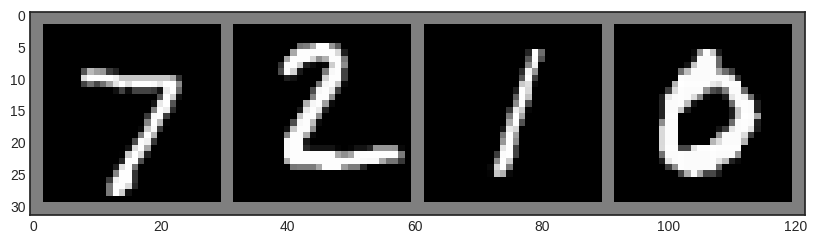

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

In [ ]:
# 모델에 이미지 전달하여 출력 계산

outputs = net(images)

In [ ]:
# 각 이미지에 대한 최대 값과 해당 인덱스 찾기

_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([7, 2, 1, 0, 4, 1, 4, 4, 3, 4, 0, 0, 4, 0, 1, 3, 4, 7, 6, 4, 4, 6, 4, 3,
        4, 0, 7, 4, 3, 1, 3, 1, 3, 2, 3, 2, 7, 1, 3, 1, 1, 7, 4, 3, 3, 3, 3, 3,
        4, 4, 6, 3, 3, 3, 6, 3, 4, 1, 4, 1, 7, 2, 3, 3, 4, 3, 2, 4, 3, 0, 7, 0,
        2, 3, 1, 4, 3, 7, 1, 7, 7, 6, 2, 7, 3, 4, 7, 3, 6, 1, 3, 6, 1, 3, 1, 4,
        3, 4, 6, 4, 6, 0, 3, 4, 4, 4, 2, 1, 4, 4, 3, 1, 3, 4, 3, 4, 4, 4, 4, 6,
        3, 4, 7, 6, 4, 4, 0, 3])


In [ ]:
# 예측된 클래스 인덱스들을 텍스트로 출력

print(''.join('{}\t'.format(str(predicted[j].numpy()))  for j in range(4)))

7	2	1	0	


In [ ]:
# 정확한 예측과 전체 이미지 수를 저장할 변수 초기화
correct = 0
total = 0

with torch.no_grad():
  # 테스트 데이터셋을 반복하여 예측 수행
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    # 모델에 이미지 전달하여 출력 계산
    outputs = net(images)
    # 각 이미지에 대한 최대 값과 해당 인덱스 찾기
    _, predicted = torch.max(outputs.data,1)
    # 전체 이미지 수 업데이트
    total += labels.size(0)
    # 정확하게 예측된 이미지 수 업데이트
    correct += (predicted == labels).sum().item()

# 정확도 계산 및 출력
print(100*correct / total)

68.09
